In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os
os.chdir('C:\\Users\\222-04\\Downloads\\gennn')
os.getcwd()

'C:\\Users\\222-04\\Downloads\\gennn'

In [8]:
train_gen_sca=pd.read_csv('train_gen_drop_na_sca.csv',encoding='cp949')
test_gen_sca=pd.read_csv('test_gen_drop_na_sca.csv',encoding='cp949')

In [9]:
train_gen_sca.columns

Index(['Unnamed: 0', 'level_0', 'index', 'application_id', 'is_applied',
       'gender', 'income_type', 'employment_type', 'houseown_type', 'purpose',
       'bank_id', 'product_id', 'loan_limit', 'loan_rate', 'credit_score',
       'yearly_income', 'desired_amount', 'existing_loan_cnt',
       'existing_loan_amt', '근속개월', 'age'],
      dtype='object')

In [10]:
test_gen_sca.columns

Index(['Unnamed: 0', 'index', 'application_id', 'is_applied', 'gender',
       'income_type', 'employment_type', 'houseown_type', 'purpose', 'bank_id',
       'product_id', 'loan_limit', 'loan_rate', 'credit_score',
       'yearly_income', 'desired_amount', 'existing_loan_cnt',
       'existing_loan_amt', '근속개월', 'age'],
      dtype='object')

In [11]:
train_gen_sca.drop(['Unnamed: 0', 'level_0', 'index'], axis=1, inplace=True)

In [13]:
test_gen_sca.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)

## Sampling

#### 1) 더미변수 

In [20]:
train_gen_sca.columns

Index(['application_id', 'is_applied', 'gender', 'income_type',
       'employment_type', 'houseown_type', 'purpose', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'credit_score', 'yearly_income',
       'desired_amount', 'existing_loan_cnt', 'existing_loan_amt', '근속개월',
       'age'],
      dtype='object')

In [21]:
final=pd.get_dummies(train_gen_sca, columns=['income_type', 'employment_type', 'houseown_type', 'purpose'])

In [22]:
final.columns

Index(['application_id', 'is_applied', 'gender', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'credit_score', 'yearly_income',
       'desired_amount', 'existing_loan_cnt', 'existing_loan_amt', '근속개월',
       'age', 'income_type_EARNEDINCOME', 'income_type_EARNEDINCOME2',
       'income_type_FREELANCER', 'income_type_OTHERINCOME',
       'income_type_PRACTITIONER', 'income_type_PRIVATEBUSINESS',
       'employment_type_계약직', 'employment_type_기타', 'employment_type_일용직',
       'employment_type_정규직', 'houseown_type_기타가족소유', 'houseown_type_배우자',
       'houseown_type_자가', 'houseown_type_전월세', 'purpose_기타', 'purpose_대환대출',
       'purpose_사업자금', 'purpose_생활비', 'purpose_자동차구입', 'purpose_전월세보증금',
       'purpose_주택구입', 'purpose_투자'],
      dtype='object')

#### 2) sampling

In [23]:
final.is_applied.value_counts()

0.0    8227485
1.0     457909
Name: is_applied, dtype: int64

In [26]:
import seaborn as sns

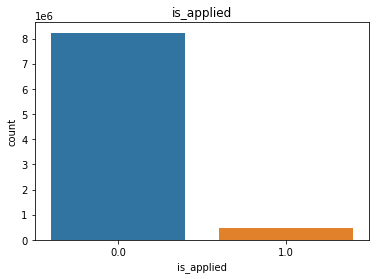

In [28]:
sns.countplot(x="is_applied", data=final)
plt.title('is_applied')
plt.show()

# 불균형 데이터 비율 추출을 위한 층화추출

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=777)
for train_idx, test_idx in split.split(final, final["is_applied"]):
    tr = final.loc[train_idx]
    val = final.loc[test_idx]

In [30]:
print(tr["is_applied"].value_counts() / len(tr))
val["is_applied"].value_counts() / len(val)

0.0    0.947278
1.0    0.052722
Name: is_applied, dtype: float64


0.0    0.947278
1.0    0.052722
Name: is_applied, dtype: float64

In [31]:
from xgboost import XGBClassifier
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import classification_report

In [32]:
x_train=tr.drop(['is_applied','houseown_type_자가'], axis=1)
y_train=tr['is_applied']

In [33]:
x_val=val.drop(['is_applied','houseown_type_자가'], axis=1)
y_val=val['is_applied']

In [34]:
x_train.shape, x_val.shape

((6514045, 34), (2171349, 34))

- Grid Search 적용 X

In [35]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=-1,
    scale_pos_weight=1,
    )
#%%
xgb1.fit( x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, nthread=-1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, ...)

In [36]:
pred = xgb1.predict(x_val)

In [37]:
print(classification_report(y_val, pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.95      1.00      0.97   2056872
     class 1       0.55      0.06      0.11    114477

    accuracy                           0.95   2171349
   macro avg       0.75      0.53      0.54   2171349
weighted avg       0.93      0.95      0.93   2171349



In [38]:
from sklearn.metrics import roc_auc_score
print('roc_auc_score {}'.format(roc_auc_score(y_val, pred)))

roc_auc_score 0.5297184042320676


In [39]:
from sklearn.metrics import roc_curve

pred_positive_label = xgb1.predict_proba(x_val)[:,1]

fprs, tprs, thresholds = roc_curve(y_val, pred_positive_label)

print('샘플 추츨')
print()

thr_idx = np.arange(1, thresholds.shape[0], 6)
print('thr idx:', thr_idx)
print('thr thresholds value:', thresholds[thr_idx])
print('thr thresholds value:', fprs[thr_idx])
print('thr thresholds value:', tprs[thr_idx])

샘플 추츨

thr idx: [     1      7     13 ... 364549 364555 364561]
thr thresholds value: [9.5277625e-01 8.8894200e-01 8.7321401e-01 ... 1.3083764e-05 1.0334584e-05
 5.1821607e-06]
thr thresholds value: [4.86175124e-07 1.94470050e-06 4.37557612e-06 ... 9.98350894e-01
 9.98848251e-01 9.99663567e-01]
thr thresholds value: [0.00000000e+00 6.98830333e-05 1.39766067e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


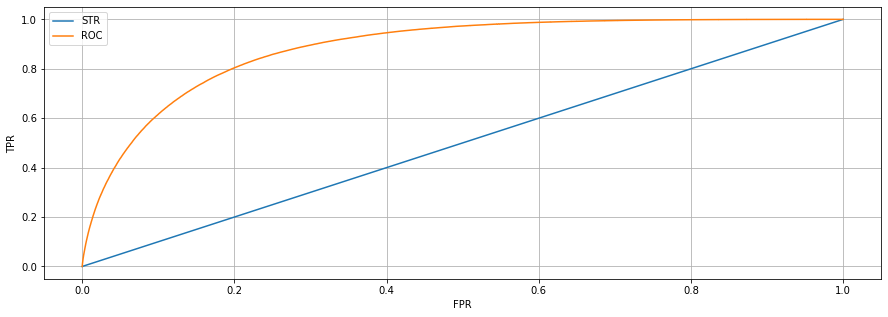

In [40]:
pred_positive_label = xgb1.predict_proba(x_val)[:,1]
fprs, tprs, thresholds = roc_curve(y_val, pred_positive_label)

precisions, recalls, thresholds = roc_curve(y_val, pred_positive_label)

plt.figure(figsize=(15, 5))

plt.plot([0,1], [0, 1], label='STR')

plt.plot(fprs, tprs, label='ROC')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid()
plt.show()

## test set 모델링

In [41]:
test_gen_sca.isnull().sum()

application_id             0
is_applied           2858748
gender                     0
income_type                0
employment_type            0
houseown_type              0
purpose                    0
bank_id                    0
product_id                 0
loan_limit                 0
loan_rate                  0
credit_score               0
yearly_income              0
desired_amount             0
existing_loan_cnt          0
existing_loan_amt          0
근속개월                       0
age                        0
dtype: int64

In [42]:
## 더미변수 생성
test=pd.get_dummies(test_gen_sca, columns=['income_type', 'employment_type', 'houseown_type', 'purpose'])

In [43]:
test_x=test.drop(['is_applied','houseown_type_자가'], axis=1)

In [48]:
xgb1_pred=xgb1.predict(test_x)
test_x.tail()

,application_id,gender,bank_id,product_id,loan_limit,loan_rate,credit_score,yearly_income,desired_amount,existing_loan_cnt,...,houseown_type_배우자,houseown_type_전월세,purpose_기타,purpose_대환대출,purpose_사업자금,purpose_생활비,purpose_자동차구입,purpose_전월세보증금,purpose_주택구입,purpose_투자
2858743,2167778,1.0,0.296296,0.744828,-0.625000,0.177419,-0.142857,0.00,-0.425,2.000000,...,0,0,0,0,0,1,0,0,0,0
2858744,2167791,1.0,0.037037,-0.834483,-0.541667,-0.080645,-0.238095,0.70,-0.175,0.666667,...,0,0,0,0,1,0,0,0,0,0
2858745,2167822,1.0,-0.888889,-0.006897,-0.333333,0.370968,-0.761905,-1.15,-0.500,0.000000,...,0,0,0,0,0,1,0,0,0,0
2858746,2167822,1.0,-0.888889,-0.586207,-0.291667,0.370968,-0.761905,-1.15,-0.500,0.000000,...,0,0,0,0,0,1,0,0,0,0
2858747,2167822,1.0,0.074074,0.048276,-0.291667,0.806452,-0.761905,-1.15,-0.500,0.000000,...,0,0,0,0,0,1,0,0,0,0


In [49]:
a1 = pd.DataFrame(xgb1_pred)
a1.tail()

,0
2858743,0
2858744,0
2858745,0
2858746,0
2858747,0


In [50]:
a1.head()

,0
0,0
1,0
2,0
3,0
4,1


In [51]:
gen_drop_na = test_gen_sca.copy()
gen_drop_na['is_applied']=xgb1_pred
gen_drop_na.tail()

,application_id,is_applied,gender,income_type,employment_type,houseown_type,purpose,bank_id,product_id,loan_limit,loan_rate,credit_score,yearly_income,desired_amount,existing_loan_cnt,existing_loan_amt,근속개월,age
2858743,2167778,0,1.0,EARNEDINCOME2,계약직,자가,생활비,0.296296,0.744828,-0.625000,0.177419,-0.142857,0.00,-0.425,2.000000,4.960115,-0.254902,-0.357143
2858744,2167791,0,1.0,PRIVATEBUSINESS,기타,기타가족소유,사업자금,0.037037,-0.834483,-0.541667,-0.080645,-0.238095,0.70,-0.175,0.666667,0.027912,-0.392157,0.928571
2858745,2167822,0,1.0,EARNEDINCOME,기타,기타가족소유,생활비,-0.888889,-0.006897,-0.333333,0.370968,-0.761905,-1.15,-0.500,0.000000,-0.497512,-0.549020,-0.857143
2858746,2167822,0,1.0,EARNEDINCOME,기타,기타가족소유,생활비,-0.888889,-0.586207,-0.291667,0.370968,-0.761905,-1.15,-0.500,0.000000,-0.497512,-0.549020,-0.857143
2858747,2167822,0,1.0,EARNEDINCOME,기타,기타가족소유,생활비,0.074074,0.048276,-0.291667,0.806452,-0.761905,-1.15,-0.500,0.000000,-0.497512,-0.549020,-0.857143


In [52]:
gen_drop_na.to_csv('C:\\Users\\222-04\\Desktop\\gen_drop_na예측완_1014.csv')

In [52]:
test.is_applied.value_counts()

0    2838969
1      19779
Name: is_applied, dtype: int64

In [53]:
test.is_applied.value_counts()/len(test)

0    0.993081
1    0.006919
Name: is_applied, dtype: float64